Mapping the geological profile from borehole data
----

Data - 10 Borehole data | each borhole is of 30m depth and consisting of data -
1. UCS (unaxial compressive strength)
2. RQD (rock quality designation)

Objective - Mapping the rock profile from given borehole data.

note: To derive the RMR (Rock Mass Rating) - the rating for UCS and RQD at each level is used (as per IS code) 
(RMR is added as a new column)

In [0]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

import sklearn
from sklearn.ensemble import RandomForestRegressor

from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from tqdm import tqdm_notebook

import torch
import torch.nn as nn
import torch.optim as optim

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Data Preprocessing

In [16]:
data_file = '/content/drive/My Drive/Colab Notebooks/Projects/Side Projects/Rock Profile/ucs_rqd_data.csv'
data = pd.read_csv(data_file)
data.head()

,bh_no,Depth,easting,northing,R.L,UCS,RQD,chainage
0,1,8.25,276816.883,2114086.734,4.25,8.52,0.0,29.71
1,1,11.25,276816.883,2114086.734,1.25,29.61,39.0,29.71
2,1,14.25,276816.883,2114086.734,-1.75,32.95,54.0,29.71
3,1,17.25,276816.883,2114086.734,-4.75,14.70,23.0,29.71
4,1,20.25,276816.883,2114086.734,-7.75,1.68,66.0,29.71


In [0]:
def ucs_rating(ucs):
  if ucs > 250:
    return 15
  elif ucs > 100 and ucs <= 250:
    return 12
  elif ucs > 50 and ucs <= 100:
    return 7
  elif ucs > 25 and ucs <= 50:
    return 4
  elif ucs > 10 and ucs <= 25: 
    return 2
  elif ucs > 2 and ucs <= 10:
    return 1
  else:
    return 1

def rqd_rating(rqd):
  if rqd > 90:
    return 20
  elif rqd > 75 and rqd <= 90:
    return 17
  elif rqd > 50 and rqd <= 75:
    return 13
  elif rqd > 25 and rqd <= 50:
    return 8
  else:
    return 3

In [18]:
data['rmr'] = (data['UCS'].apply(ucs_rating) + data['RQD'].apply(rqd_rating))/35*100
data.head()

,bh_no,Depth,easting,northing,R.L,UCS,RQD,chainage,rmr
0,1,8.25,276816.883,2114086.734,4.25,8.52,0.0,29.71,11.428571
1,1,11.25,276816.883,2114086.734,1.25,29.61,39.0,29.71,34.285714
2,1,14.25,276816.883,2114086.734,-1.75,32.95,54.0,29.71,48.571429
3,1,17.25,276816.883,2114086.734,-4.75,14.70,23.0,29.71,14.285714
4,1,20.25,276816.883,2114086.734,-7.75,1.68,66.0,29.71,40.000000


## 2. Utility functions for training and prediction

In [19]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])


[**Issue**: scikit-learn cross validation, negative values with mean squared error](https://stackoverflow.com/questions/21443865/scikit-learn-cross-validation-negative-values-with-mean-squared-error)

In [0]:
def map_rock_profile(model,X_scaled, Y_scaled,x_min_max_scaler, y_min_max_scaler, resolution=50):        
    # 1. PREPARING THE 2-D MATRIX FOR PLOTTING
    # ====================================
    # depth
    z_cors = X_scaled['Depth'].values
    Z_cors = np.linspace(min(z_cors),max(z_cors),num=resolution)
    # chainage 
    x_cors = X_scaled['chainage'].values
    X_cors = np.linspace(min(x_cors),max(x_cors),num=resolution)

    X_grid, Z_grid = np.meshgrid(X_cors,Z_cors) 
    prop_value = np.zeros((len(X_grid),len(Z_grid)))

    for x in range(resolution):
      for z in range(resolution):       
        predict_values = np.array([Z_cors[z],X_cors[x]]).reshape(1,2)
        scaled_pred = model.predict(predict_values)
        # unnormalize the prediction
        prediction = y_min_max_scaler.inverse_transform(scaled_pred.reshape(-1,1))
        prop_value[z,x] = prediction
    
    X_data = np.transpose(np.vstack((Z_cors,X_cors)))
    X_data = x_min_max_scaler.inverse_transform(X_data)

    return prop_value, X_data

def show_profile(data, model,x_cols,pred_col,resolution):

  ## preprocessing
  X_data = data[x_cols].copy().values
  Y_data = data[pred_col].copy().values.reshape(-1,1)

  x_min_max_scaler = preprocessing.MinMaxScaler()
  y_min_max_scaler = preprocessing.MinMaxScaler()

  X_scaled = x_min_max_scaler.fit_transform(X_data)
  Y_scaled = y_min_max_scaler.fit_transform(Y_data) 

  X_scaled = pd.DataFrame(X_scaled,columns=x_cols)
  Y_scaled = pd.DataFrame(Y_scaled,columns=[pred_col])

  # model trianing
  X_train = X_scaled.values
  Y_train = Y_scaled.values.ravel()
  model.fit(X_train,Y_train)

  # prediction
  prop_values, X_pred = map_rock_profile(model,X_scaled, Y_scaled,x_min_max_scaler, y_min_max_scaler, resolution)

  # plotting
  fig = plt.figure(figsize=(15,5))
  X1_grid,Z1_grid = np.meshgrid(X_pred[:,1],X_pred[:,0])
  contour = plt.contourf(X1_grid,Z1_grid,prop_values,cmap=plt.get_cmap('jet'))
  fig.colorbar(contour)
  plt.gca().invert_yaxis()
  plt.title(pred_col.upper()+" values")
  plt.ylabel(x_cols[0])
  plt.xlabel(x_cols[1])

  ## plotting the boreholes
  depth_limits = [data[x_cols[0]].min()-2, data[x_cols[0]].max()]
  for (bh,chainage),df in data.groupby(['bh_no',x_cols[1]]):
    plt.plot([chainage,chainage],depth_limits,color='black',linestyle='--')
    plt.text(x=chainage, y = depth_limits[0]-3, s='BH-'+str(bh), rotation=90)

  plt.show()

## 3. Hyperparameter tunining for model selection

In [21]:
## preprocessing the data for modelling

x_cols = ['Depth','chainage']
pred_col = 'RQD'

X_data = data[x_cols].copy().values
Y_data = data[pred_col].copy().values.reshape(-1,1)

x_min_max_scaler = preprocessing.MinMaxScaler()
y_min_max_scaler = preprocessing.MinMaxScaler()

X_scaled = x_min_max_scaler.fit_transform(X_data)
Y_scaled = y_min_max_scaler.fit_transform(Y_data) 

X_scaled = pd.DataFrame(X_scaled,columns=x_cols)
Y_scaled = pd.DataFrame(Y_scaled,columns=[pred_col])
X_scaled.head()

,Depth,chainage
0,0.203629,0.083719
1,0.324597,0.083719
2,0.445565,0.083719
3,0.566532,0.083719
4,0.687500,0.083719


In [22]:
Y_scaled.head()

,RQD
0,0.00
1,0.39
2,0.54
3,0.23
4,0.66


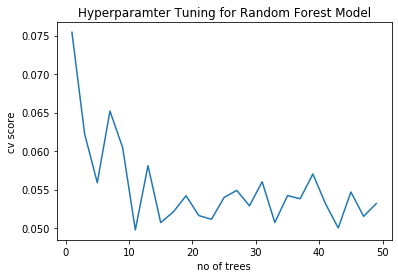

CPU times: user 7.6 s, sys: 51.2 ms, total: 7.65 s
Wall time: 7.69 s


In [23]:
%%time
no_of_trees = np.arange(1,50,2)
cv_scores = []
X_train = X_scaled.values
Y_train = Y_scaled.values.ravel()

for tree in tqdm_notebook(no_of_trees):
  model = RandomForestRegressor(n_estimators = tree)
  score = cross_val_score(model,X_train,Y_train,cv=10,scoring='neg_mean_squared_error')
  cv_scores.append(-1*np.mean(score))

plt.title('Hyperparamter Tuning for Random Forest Model')
plt.plot(no_of_trees,cv_scores)
plt.xlabel('no of trees')
plt.ylabel('cv score')
plt.show()

## 4. Prediction and Plotting the profile

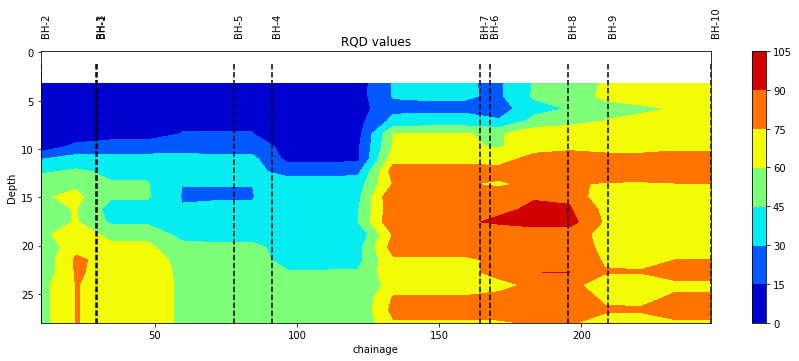

CPU times: user 1.13 s, sys: 12.2 ms, total: 1.14 s
Wall time: 1.15 s


In [100]:
%%time
model = RandomForestRegressor(n_estimators = 30)
show_profile(data,model,x_cols = ['Depth','chainage'], pred_col = 'RQD',resolution=20)

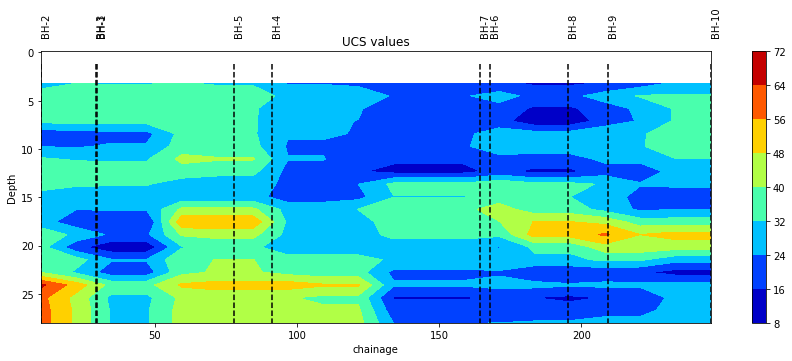

In [25]:
model = RandomForestRegressor(n_estimators = 10)
show_profile(data,model,x_cols = ['Depth','chainage'], pred_col = 'UCS',resolution=20)

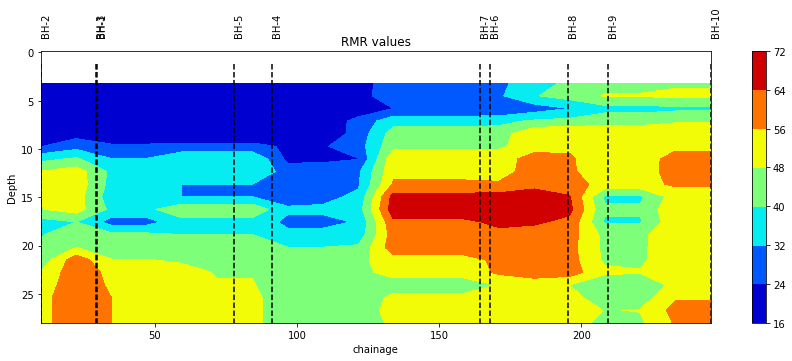

In [26]:
show_profile(data,model,x_cols = ['Depth','chainage'], pred_col = 'rmr',resolution=20)